# FORESEE Tutorial - Dark Photon

### Load Libraries 

In [1]:
import sys
src_path = "/Users/felixkling/Documents/GitHub/FORESEE"
sys.path.append(src_path)

import numpy as np
from src.foresee import Foresee, Utility, Model

from matplotlib import pyplot as plt

## 1. Initialization 


All function that we will need are included in the FORESEE package. We start by simply initializing it: 

In [2]:
foresee = Foresee()

If dark photons are sufficiently light, they are mainly produced via pion decay. To start, let us have a look at the pion spectrum in terms of the angle with respect to the beam axis $\theta$ and the momentum $p$. This can be done using the function `get_spectrumplot` which requires the MC particle ID (or simply pid), the MC generator and the energy. The units on the coloraxis are pb/bin. 

FORESEE provides the 2D spectrum as tables for a variety of particles ($\pi^0$, $\eta$, ...), generators (SIBYLL, EPOSLHC, QGSJET, PYTHIA) and collision energies (14, 27 and 100 TeV). The datafiles are stored in the directory `files/hadrons`. Let us show the $\pi^0$ spectrum here. 

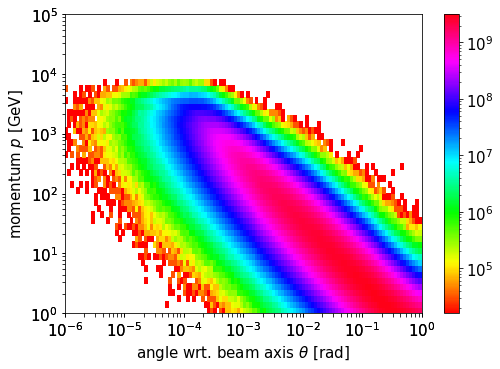

In [3]:
plot=foresee.get_spectrumplot(pid="111", generator="EPOSLHC", energy="14")
plot.show()

## 2. Specifying the Model: Dark Photons

The phenomenology of the dark photon $A'$ can be described by the following Lagrangian

\begin{equation}
 \mathcal{L} = \frac{1}{2} m_{A'}^2 A'^2  - \epsilon e \sum \bar f \gamma^\mu f A'_\mu
\end{equation}

with the dark photon mass $m_{A'}$ and the kinetic mixing parameter $\epsilon$ as free parameters. For the search for dark photons at forward experiments we need to know i) the *production rate*, ii) the *lifetime* and iii) possibly the *decay branching fractions* of dark photons as function of those two parameters. All properties are specified in the `Model` class. We initialize it with the name of the model as argument. Optionally, we can also add the `path` to the directory where the model is stored. 

In [4]:
energy = "14"
modelname="DarkPhoton"
model = Model(modelname, path="./")

**Production** Most LLPs are produced in the decay of primary particles. Here we need to specify the total branching fraction into the LLP as function of the `coupling` and the `mass`. We additionally specify the variable `nsample` which specifies how often each parent particle is decayed. 

For the dark photon, we have the branching fractions

\begin{equation}
    \text{BR}(\pi^0 \to A' \gamma) = 2 \epsilon^2 \times\text{BR}(\pi^0 \to \gamma\gamma) \times \left(1-m_{A'}^2/m_\pi^2\right)^3
    \quad\quad\text{and}\quad\quad
    \text{BR}(\eta \to A' \gamma) = 2 \epsilon^2 \times\text{BR}(\eta \to \gamma\gamma) \times \left(1-m_{A'}^2/m_\eta^2\right)^3
\end{equation}

There is also the option for 3-body decays $p_0 \to p_1 p_2 p_3$ with $p_3$ being the LLP. This can be added using the function `add_production_3bodydecay()`. It requires to provide `br` which is the differential branching fraction $d\text{BR}/(dq \ d\cos\vartheta)$ where $q^2=(p_2+p_3)^2$ and $\vartheta$ is the angle between $p_3$ in the restframe of $p_2+p_3$ and the direction of $p_2+p_3$ in the restframe of $p_0$. We do not have an example for this in the dark photon case. 

In [5]:
model.add_production_2bodydecay(
    pid0 = "111",
    pid1 = "22",
    br = "2.*0.99 * coupling**2 * pow(1.-pow(mass/self.masses('111'),2),3)",
    generator = "EPOSLHC",
    energy = energy,
    nsample = 10
)

model.add_production_2bodydecay(
    pid0 = "221",
    pid1 = "22",
    br = "2.*0.39 * coupling**2 * pow(1.-pow(mass/self.masses('221'),2),3)",
    generator = "EPOSLHC",
    energy = energy,
    nsample = 10, 
)

We can also produce the dark photon via it's resonant mixing with the SM vector mesons, in particular the $\omega$, $\rho$ and $\phi$ mesons. Following [arXiv:1810.01879](https://arxiv.org/pdf/1810.01879.pdf), we can write 

\begin{equation}
    \sigma(A') = \theta_V^2 \  \sigma(V)
    \quad\quad\text{with}\quad\quad
    \theta_V = \frac{\epsilon e}{g_V}  \frac{m_V^2}{m_{A'}^2 - m_V^2 + i m_V \Gamma_V}
\end{equation}

Here $g_\omega = 17$, $g_\rho=5$ and $g_\phi=-12.88$. We can specify this production mode using `model.add_production_mixing()`. In the following, we focus on the $\rho$, which provides the leading contribution. 

In [6]:
model.add_production_mixing(
    pid = "113",
    mixing = "coupling * 0.3/5. * 0.77545**2/abs(mass**2-0.77545**2+0.77545*0.147*1j)",
    generator = "EPOSLHC",
    energy = energy,
)

Particles can also be produced directly in collisions. In the case of dark photons, this proceeds through Bremsstrahlung at lower masses or through Drell-Yan production at higher masses. The spectra for LLPs at some reference coupling need to be provided for a fixed set of masses in the `model/direct` directory. We also provide an option to implement additional conditions in terms of the momentum `p`, in this case the requirement that pT of dark photon produced in Bremssteahlung is smaller than 1 GeV.

In [7]:
masses_brem = [ 
    0.01  ,  0.0126,  0.0158,  0.02  ,  0.0251,  0.0316,  0.0398,
    0.0501,  0.0631,  0.0794,  0.1   ,  0.1122,  0.1259,  0.1413,
    0.1585,  0.1778,  0.1995,  0.2239,  0.2512,  0.2818,  0.3162,
    0.3548,  0.3981,  0.4467,  0.5012,  0.5623,  0.6026,  0.631 ,
    0.6457,  0.6607,  0.6761,  0.6918,  0.7079,  0.7244,  0.7413,
    0.7586,  0.7762,  0.7943,  0.8128,  0.8318,  0.8511,  0.871 ,
    0.8913,  0.912 ,  0.9333,  0.955 ,  0.9772,  1.    ,  1.122 ,
    1.2589,  1.4125,  1.5849,  1.7783,  1.9953,  2.2387,  2.5119,
    2.8184,  3.1623,  3.9811,  5.0119,  6.3096,  7.9433, 10.    
]

model.add_production_direct(
    label = "Brem",
    energy = energy,
    condition = "p.pt<1",
    coupling_ref=1,
    masses = masses_brem,
)

masses_dy = [ 
    1.5849,  1.7783,  1.9953,  2.2387,  2.5119, 2.8184,  3.1623,  3.9811,  5.0119,  6.3096,  7.9433, 10.    
]

model.add_production_direct(
    label = "DY",
    energy = energy,
    coupling_ref=1,
    masses = masses_dy,
)

**Lifetime:** For most models the lifetime can be written as $\ c\tau(m,g)\  =\  c\tau(m,g_*) \ \cdot\  g_*^2 \ / \ g^{2}$ where $m$ is the mass, $g$ is the coupling and $g_*$ is some reference coupling. In this case, we can provide a table of masses $m$ and lifetimes $c\tau(m,g_*)$ at a reference coupling $g_*$ using `model.set_ctau_1d`. Alternatively, one can also provide a table of masses $m$, couplings $g$ and lifetimes $c\tau(m,g)$ via `model.set_ctau_2d()`. 

In [8]:
model.set_ctau_1d(
    filename="model/ctau.txt", 
    coupling_ref=1
)

**Branching Fractions:** For most models, the branching fractions into particular decay channels are independent of the overall couplings. In this case, we can provide a set of tables of masses $m$ and branching fractions $BR(m)$ using `model.set_br_1d`. Alternatively, we can also provide table of masses $m$, couplings $g$ and brnaching fraction $BR(m,g)$ via `model.set_br_2d()`. In both cases, we need to specify a list of decay modes and a list of filenames with the corresponding data tables. 

In [9]:
model.set_br_1d(
    modes=["e_e", "mu_mu"],
    finalstates=[[11,-11], [13,-13]],
    filenames=["model/br/e_e.txt","model/br/mu_mu.txt"]
)

## 3. Generate LLP Spectra

After we have specified the model, let us generate the LLP spectra. We first set the model we just created. 

In [10]:
foresee.set_model(model=model)

Let's first look at one benchmark scenario with $m_{A'}=100$ MeV and $\epsilon=10^{-5}$ using the function `foresee.get_llp_spectrum()`. By default, the result are saved in the `model/LLP_spectra` directory. However, here set `save_file=False` since we don't want to save the results but set `do_plot=True` to plot them. 

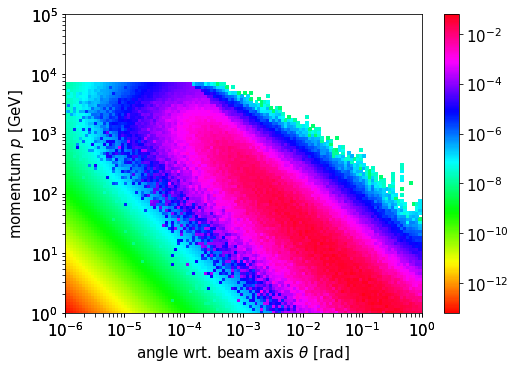

In [11]:
plot = foresee.get_llp_spectrum(0.1, coupling=10**(-5), do_plot=True, save_file=False)
plot.show()

We can now produce a set of LLP spectra for various masses  (chosen to be equally spaced in log(mass)) and unit coupling and save them. 

In [12]:
masses = [ 
    0.01  ,  0.0126,  0.0158,  0.02  ,  0.0251,  0.0316,  0.0398,
    0.0501,  0.0631,  0.0794,  0.1   ,  0.1122,  0.1259,  0.1413,
    0.1585,  0.1778,  0.1995,  0.2239,  0.2512,  0.2818,  0.3162,
    0.3548,  0.3981,  0.4467,  0.5012,  0.5623,  0.6026,  0.631 ,
    0.6457,  0.6607,  0.6761,  0.6918,  0.7079,  0.7244,  0.7413,
    0.7586,  0.7762,  0.7943,  0.8128,  0.8318,  0.8511,  0.871 ,
    0.8913,  0.912 ,  0.9333,  0.955 ,  0.9772,  1.    ,  1.122 ,
    1.2589,  1.4125,  1.5849,  1.7783,  1.9953,  2.2387,  2.5119,
    2.8184,  3.1623,  3.9811,  5.0119,  6.3096,  7.9433, 10.    
]

for mass in masses:
    foresee.get_llp_spectrum(mass=mass,coupling=1)

save data to file: ./model/LLP_spectra/14TeV_111_m_0.01.npy
save data to file: ./model/LLP_spectra/14TeV_221_m_0.01.npy
save data to file: ./model/LLP_spectra/14TeV_113_m_0.01.npy
save data to file: ./model/LLP_spectra/14TeV_Brem_m_0.01.npy
save data to file: ./model/LLP_spectra/14TeV_111_m_0.0126.npy
save data to file: ./model/LLP_spectra/14TeV_221_m_0.0126.npy
save data to file: ./model/LLP_spectra/14TeV_113_m_0.0126.npy
save data to file: ./model/LLP_spectra/14TeV_Brem_m_0.0126.npy
save data to file: ./model/LLP_spectra/14TeV_111_m_0.0158.npy
save data to file: ./model/LLP_spectra/14TeV_221_m_0.0158.npy
save data to file: ./model/LLP_spectra/14TeV_113_m_0.0158.npy
save data to file: ./model/LLP_spectra/14TeV_Brem_m_0.0158.npy
save data to file: ./model/LLP_spectra/14TeV_111_m_0.02.npy
save data to file: ./model/LLP_spectra/14TeV_221_m_0.02.npy
save data to file: ./model/LLP_spectra/14TeV_113_m_0.02.npy
save data to file: ./model/LLP_spectra/14TeV_Brem_m_0.02.npy
save data to file: .

save data to file: ./model/LLP_spectra/14TeV_113_m_1.0.npy
save data to file: ./model/LLP_spectra/14TeV_Brem_m_1.0.npy
save data to file: ./model/LLP_spectra/14TeV_113_m_1.122.npy
save data to file: ./model/LLP_spectra/14TeV_Brem_m_1.122.npy
save data to file: ./model/LLP_spectra/14TeV_113_m_1.2589.npy
save data to file: ./model/LLP_spectra/14TeV_Brem_m_1.2589.npy
save data to file: ./model/LLP_spectra/14TeV_113_m_1.4125.npy
save data to file: ./model/LLP_spectra/14TeV_Brem_m_1.4125.npy
save data to file: ./model/LLP_spectra/14TeV_113_m_1.5849.npy
save data to file: ./model/LLP_spectra/14TeV_Brem_m_1.5849.npy
save data to file: ./model/LLP_spectra/14TeV_DY_m_1.5849.npy
save data to file: ./model/LLP_spectra/14TeV_Brem_m_1.7783.npy
save data to file: ./model/LLP_spectra/14TeV_DY_m_1.7783.npy
save data to file: ./model/LLP_spectra/14TeV_Brem_m_1.9953.npy
save data to file: ./model/LLP_spectra/14TeV_DY_m_1.9953.npy
save data to file: ./model/LLP_spectra/14TeV_Brem_m_2.2387.npy
save data t

## 4. Count Eventrate in Detector

Before counting the number of decays within the detector volume, let us specify the detector geometry. For this we need

- the `distance` from the IP in meter (default: 480)
- the `length` in meter (default: 5)
- the `luminosity` in units of fb^-1 (default: 3000)
- the `selection` depending in `x.x` and `x.y` (default: `np.sqrt(x.x**2 + x.y**2)< 1`)
- the decay `channels` which the detector can see (default: None, meaning all of them)

The default correspond to the FASER2 detector.

In [13]:
distance, selection, length, luminosity, channels = 480, "np.sqrt(x.x**2 + x.y**2)< 1", 5, 3000, None
foresee.set_detector(distance=distance, selection=selection, length=length, luminosity=luminosity, channels=channels)

Let us look for one specific dark photon mass $m_{A'}=100$ MeV at how many particle decay inside the decay volume. This can be done using `get_events()` for which we need to specify again the mass and filename. Additionally, we can specify 

- the `couplings` for which we evaluate the event rate as numpy array (deault `np.logspace(-8,-3,51)`)
- the `preselectioncuts` when reading the LLP spectra in terms of momentum `p` and angle `th` (default: `th<0.01 and p>100`)
- the number `nsample` describing how many randomly choosen values of $\phi_{LLP}$ should sampled (default 1). This is only relevant for detectors that are not cylyndrical or not centered around the beam axis. 
- the production `modes` which should be considered
- the `energy` of the experiments

In [21]:
mass = 0.1 
output = foresee.get_events(mass=mass, energy=energy, couplings=np.logspace(-8,-3,6))
coups, ctaus, nsigs, energies, weights, _ = output
for coup,ctau,nsig in zip(coups, ctaus, nsigs):
    print ("epsilon =", '{:5.3e}'.format(coup), ": nsignal =", '{:5.3e}'.format(nsig))

epsilon = 1.000e-08 : nsignal = 2.099e-06
epsilon = 1.000e-07 : nsignal = 2.092e-02
epsilon = 1.000e-06 : nsignal = 1.537e+02
epsilon = 1.000e-05 : nsignal = 8.962e+02
epsilon = 1.000e-04 : nsignal = 7.117e-33
epsilon = 1.000e-03 : nsignal = 0.000e+00


The previous function also outputs the energy distribution of the dark photons which decay inside the detector. Let's have a look at them.

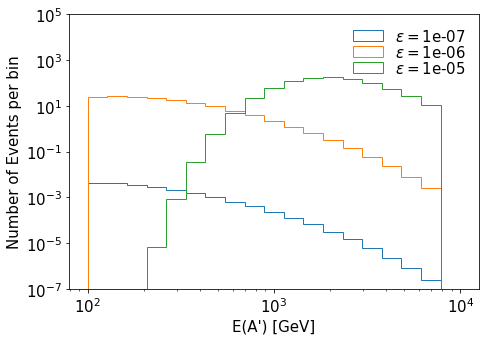

In [22]:
fig = plt.figure(figsize=(7,5))
ax = plt.subplot(1,1,1)
ens=[]
for coup,en,weight in zip(coups,energies,weights):
    if sum(weight)<10**-5 : continue
    ens.append(en)
    ax.hist(en, weights=weight, bins=np.logspace(2,4, 20), histtype='step', label=r"$\epsilon=$"+str(coup)) 
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_ylim(10**-7,10**5) 
    ax.set_xlabel("E(A') [GeV]") 
    ax.set_ylabel("Number of Events per bin") 
    ax.legend(frameon=False, labelspacing=0)
plt.tight_layout()
plt.show()

FORESEE also includes a function `write_events()` which obtains an unweighted sample of LLP decay events and saves them as a HEPMC file. For this function, we need to specify
- the `mass` and `coupling` of the LLP
- the collision `energy`
- the number of events `numberevent` that should be samples (optional, default=10)
- the `filename` of the output file (optional, default=`model/events/<mass>_<coupling>.hepmc`)
- the z-position (in meter) of the beginning of the decay volume (optional, default=0)
- a random `seed` (optional, default=None)

At the moment, FORESEE only supports 2-body LLP decays. For all other cases, including those where no final state information was specified when initiating the `Model`, the LLP will not be decayed. 

In [24]:
foresee.write_events(filename="model/events/test.hepmc", mass=.1, coupling=1e-5, energy="14", numberevent=3, zfront=0)

/Users/felixkling/Documents/GitHub/FORESEE/src/foresee.py:888: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  channels=np.array(channels).T


Let us have a look at a the output:

In [25]:
f = open("model/events/test.hepmc", 'r')
file_contents = f.read()
print (file_contents)

HepMC::Version 2.06.09
HepMC::IO_GenEvent-START_EVENT_LISTING
E 0 -1 -1. -1. -1. 0 -1 1 1 0 0 0
U GEV MM
C 300.44734856658204 0.
F 0 0 0 0 0 0 0 0 0
V -1 0 54.3334030996 43.6543907422 2553.4499016907 1083416201468.6428 1 2 0
P 1 32 0.2532918906 0.2035083859 2237.6678008498 2237.6678266741 0.1000000035 2 0 0 -1 0
P 2 11 0.1161267188 0.1479295468 1416.8889258155 1416.8889382967 0.0005106568 1 0 0 0 0
P 3 -11 0.137165163 0.0555788319 820.7787968455 820.7788101887 0.0005108847 1 0 0 0 0
E 1 -1 -1. -1. -1. 0 -1 1 1 0 0 0
U GEV MM
C 300.44734856658204 0.
F 0 0 0 0 0 0 0 0 0
V -1 0 -3.5894718961 -27.9914624008 3998.2858406528 1696349803672.188 1 2 0
P 1 32 -0.0106049763 -0.0826998522 1418.1441622812 1418.1441682579 0.1 2 0 0 -1 0
P 2 11 0.0035147932 -0.0989674451 1314.8528542331 1314.8528579625 0.0005111125 1 0 0 0 0
P 3 -11 -0.0141197693 0.016267594 103.2912894877 103.291291735 0.0005110146 1 0 0 0 0
E 2 -1 -1. -1. -1. 0 -1 1 1 0 0 0
U GEV MM
C 300.44734856658204 0.
F 0 0 0 0 0 0 0 0 0
V -1 

## 5. Parameter Scan

In the following, we will get the LLP sensitivity reach for different detector configuraions. As an example, we show the FASER2 reach for dark photons for 3 scenarios. We just need to loop over different masses and use the previously introduced funtion `get_events`. The results will be written into a `.npy` file that we can store and plot later.

- the nominal/default setup

In [26]:
#specify setup
luminosity, distance = 3000 , 480
setup, selection, channels = "default", "np.sqrt(x.x**2 + x.y**2)< 1", None
foresee.set_detector(selection=selection, channels=channels, distance=distance, luminosity=luminosity)

#get reach 
list_nevents = []    
for mass in masses:
    couplings, _, nevents, _, _ , _ = foresee.get_events(mass=mass, energy=energy)
    list_nevents.append(nevents)  
    
#save results
np.save(model.modelpath+"model/results/"+energy+"TeV_"+setup+".npy",[masses,couplings,list_nevents])

/Users/felixkling/anaconda/envs/python3/lib/python3.6/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


- a displaced setup, in which the detector is displaced by 1m from it's nominal position

In [27]:
#specify setup
luminosity, distance = 3000 , 480
setup, selection, channels = "displaced", "np.sqrt((x.x-1)**2 + x.y**2)< 1", None
foresee.set_detector(selection=selection, channels=channels, distance=distance, luminosity=luminosity)

#get reach 
list_nevents = []    
for mass in masses:
    couplings, _, nevents, _, _ , _ = foresee.get_events(mass=mass, energy=energy)
    list_nevents.append(nevents)  
    
#save results
np.save(model.modelpath+"model/results/"+energy+"TeV_"+setup+".npy",[masses,couplings,list_nevents])

- a search that only considered dark photon decays into electrons 

In [28]:
#specify setup
luminosity, distance = 3000 , 480
setup, selection, channels = "electron", "np.sqrt(x.x**2 + x.y**2)< 1", ["e_e"]
foresee.set_detector(selection=selection, channels=channels, distance=distance, luminosity=luminosity)

#get reach 
list_nevents = []    
for mass in masses:
    couplings, _, nevents, _, _ , _ = foresee.get_events(mass=mass, energy=energy)
    list_nevents.append(nevents)  
    
#save results
np.save(model.modelpath+"model/results/"+energy+"TeV_"+setup+".npy",[masses,couplings,list_nevents])

## 6. Plot the Results

Now let's plot the results. We first specify all detector setups for which we want to show result (filename in model/results directory, label, color, linestyle, opacity alpha for filled contours, required number of events).

In [29]:
setups = [
    ["14TeV_default.npy",    "default"  , "red",     "solid", 0., 3],
    ["14TeV_displaced.npy",  "displaced", "orange",  "solid", 0., 3],
    ["14TeV_electron.npy",   "electron" , "magenta", "solid", 0., 3],
]

Then we specify all the existing bounds (filename in model/bounds directory, label, label position x, label position y, label rotation)

In [30]:
bounds = [ 
    ["bounds_LHCb1.txt", "LHCb",  0.220, 0.9*10**-4, 0  ],
    ["bounds_LHCb2.txt",  None  , 0    , 0         , 0  ],
    ["bounds_LHCb3.txt",  None  , 0    , 0         , 0  ],
    ["bounds_E137.txt",  "E137",  0.015, 1.2*10**-7, 0  ],
    ["bounds_Charm.txt", "CHARM", 0.120, 1.3*10**-7, -8 ],
    ["bounds_NuCal.txt", "NuCal", 0.041, 8.0*10**-6, -24],
    ["bounds_E141.txt",  "E141",  0.011, 7.5*10**-5, 17 ],
    ["bounds_NA64.txt",  "NA64",  0.013, 2.3*10**-4, -35],
    ["bounds_BaBar.txt", "BaBar", 0.360, 1.4*10**-3, 0  ],
    ["bounds_NA48.txt",  "NA48",  0.040, 1.4*10**-3, 0  ],
]

We then specify other projected sensitivitities (filename in model/bounds directory, color, label, label position x, label position y, label rotation)

In [31]:
projections = [
    ["limits_SeaQuest.txt",       "lime",         "SeaQuest", 1.350, 2.1*10**-7, 0  ],
    ["limits_NA62.txt",           "limegreen",    "NA62"    , 0.999, 1.1*10**-7, 0  ],
    ["limits_SHiP.txt",           "forestgreen",  "SHiP"    , 1.750, 8.2*10**-7, 0  ],
    ["limits_HPS-prompt.txt",     "deepskyblue",  "HPS"     , 0.050, 1.5*10**-4, 0  ],
    ["limits_HPS-displaced.txt",  "deepskyblue",  None      , 0.050, 1.5*10**-4, 0  ],
    ["limits_Belle2.txt",         "blue",         "Belle2"  , 0.570, 1.3*10**-4, 0  ],
    ["limits_LHCb.txt",           "dodgerblue",   "LHCb"    , 0.135, 2.8*10**-4, 0  ],
    ["limits_LHCb-mumu1.txt",     "dodgerblue",   None      , 0    , 0         , 0  ],
    ["limits_LHCb-mumu2.txt",     "dodgerblue",   None      , 0    , 0         , 0  ],
]

Finally, we can plot everything using `foresee.plot_reach()`. It returns a matplotlib instance, to which we can add further lines and which we can show or save. Below, we add the dark matter relict target line for a specific benchmark.

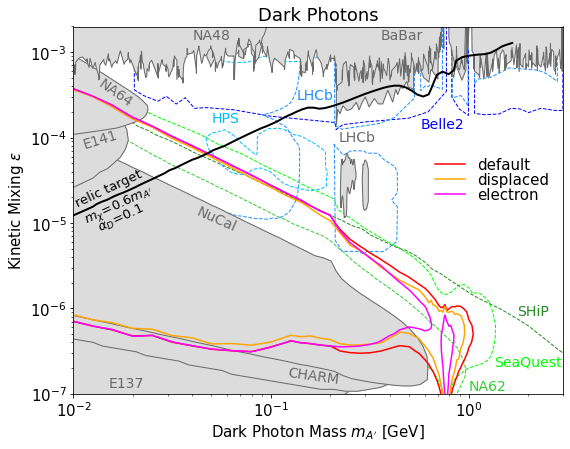

In [32]:
plot = foresee.plot_reach(
    setups=setups,
    bounds=bounds,
    projections=projections,
    title="Dark Photons", 
    xlims = [0.01,3], 
    ylims=[10**-7,0.002],
    xlabel=r"Dark Photon Mass $m_{A'}$ [GeV]", 
    ylabel=r"Kinetic Mixing $\epsilon$",
    legendloc=(1,0.68),
    figsize=(8,6),
)

data = foresee.readfile("model/lines/scalar_DM_Oh2_intermediate_eps_vs_mAprime.txt")
plot.plot(data.T[0], data.T[1], color="k", lw=2)
plot.text(0.010, 1.55*10**-5, "relic target",  fontsize=13,color="k",rotation=25)
plot.text(0.011, 1.02*10**-5, r"$m_\chi\!=\!0.6 m_{A'}$",fontsize=13,color="k",rotation=25)
plot.text(0.013, 8.00*10**-6, r"$\alpha_D\!=\!0.1$",fontsize=13,color="k",rotation=25)

plot.subplots_adjust(left=0.12, right=0.97, bottom=0.10, top=0.95)
plot.savefig("/Users/felixkling/Downloads/Figure.pdf")
plot.show()

## 7. Export Contours

It might also be useful to extract the contours lines, and save them as a text file. This can be done using the `extract_contours()` function. As example, let us export the FASER2 line. 

In [21]:
foresee.extract_contours(
    inputfile="model/results/14TeV_default.npy", 
    outputfile="model/lines/limits_FASER2.txt"
)